# Train Two-layer Classifier with Pre-extracted Features

The code below is used for testing structures and tuning hyperparameters of last two fully-connected layers, which take extracted features as input, and return the label of each song. 

In this script, different regularization methods are tested and plots of each test result are presented.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Input, Dense, merge, Flatten, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras.models import Model
from kapre.time_frequency import Melspectrogram
from keras.regularizers import l2

Using Theano backend.


## Paths to dataset

Here we directly used output of CNN ("pre-trained convnet feature" vectors) as the input. These vectors are stored as .npy files in `[PATH_TO_HOME]/dataset/data_feats/`. 

The path of each their labels is `[PATH_TO_HOME]/dataset/Y.npy`.

In [4]:
PATH_Xs = ['./dataset/data_feats/gtzan_genre_layer_0.npy',
          './dataset/data_feats/gtzan_genre_layer_1.npy',
          './dataset/data_feats/gtzan_genre_layer_2.npy',
          './dataset/data_feats/gtzan_genre_layer_3.npy',
          './dataset/data_feats/gtzan_genre_layer_4.npy']
          
PATH_Y = './dataset/Y.npy'

## Load Dataset

In [5]:
# Load X
X = np.concatenate([np.load(path) for path in PATH_Xs], axis=1) # Concatenate features from 5 intermediate layers

# Load Y
Y_pre = np.load(PATH_Y)
Y = np.zeros((1000, 10))
Y[np.arange(1000), Y_pre] = 1

# Split Dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

## Models

Here we tested 7 different structures, which are:
- 1-layer without regularization
- 1-layer with L2 regularization
- 2-layer without regularization
- 2-layer with L2 regularization on both layers
- 2-layer with L2 regularizaiton on the first layer
- 2-layer with L2 regularizaiton on the second layer
- 2-layer with dropout

In [179]:
def model_2_layer(lambd=0.1, mid_ns=32):
    '''
    2-layer model without regularizations.
    '''
    x = Input(shape=(160,))

    dense1 = Dense(mid_ns, input_shape=[160], activation='relu')(x)

    out = Dense(10, input_shape=[mid_ns], activation='softmax')(dense1)

    model = Model(input=x, output=out)

    return model


def model_1_layer(lambd=0.1):
    '''
    1-layer model.
    '''
    x = Input(shape=(160,))

    out = Dense(10, input_shape=[160], activation='softmax')(x)
    
    model = Model(input=x, output=out)
    
    return model


def model_1_layer_L2(lambd = 0.01):
    '''
    1-layer model.
    '''
    x = Input(shape=(160,))

    out = Dense(10, input_shape=[160], W_regularizer=l2(lambd), activation='softmax')(x)
    
    model = Model(input=x, output=out)
    
    return model


def model_2_layer_L2(lambd = 0.005, mid_ns=32):
    '''
    2-layer model with xxx regularization.
    '''
    x = Input(shape=(160,))

    dense1 = Dense(mid_ns, input_shape=[160], W_regularizer=l2(lambd), activation='relu')(x)

    out = Dense(10, input_shape=[mid_ns], W_regularizer=l2(lambd), activation='softmax')(dense1)

    model = Model(input=x, output=out)
    
    return model


def model_2_layer_first_L2(lambd = 0.005, mid_ns=32):
    '''
    2-layer model with xxx regularization.
    '''
    x = Input(shape=(160,))

    dense1 = Dense(mid_ns, input_shape=[160], W_regularizer=l2(lambd), activation='relu')(x)

    out = Dense(10, input_shape=[mid_ns], activation='softmax')(dense1)

    model = Model(input=x, output=out)
    
    return model


def model_2_layer_last_L2(lambd = 0.005, mid_ns=32):
    '''
    2-layer model with xxx regularization.
    '''
    x = Input(shape=(160,))

    dense1 = Dense(mid_ns, input_shape=[160], activation='relu')(x)

    out = Dense(10, input_shape=[mid_ns], W_regularizer=l2(lambd), activation='softmax')(dense1)

    model = Model(input=x, output=out)
    
    return model


def model_2_layer_DR(lambd = 0.2, mid_ns=32):
    '''
    2-layer model with xxx regularization.
    '''
    x = Input(shape=(160,))

    dense1 = Dense(mid_ns, input_shape=[160], activation='relu')(x)
    
    dr1 = Dropout(lambd)(dense1)

    out = Dense(10, input_shape=[mid_ns], activation='softmax')(dr1)

    model = Model(input=x, output=out)
    
    return model

## K-fold Cross Validation

In [126]:
from sklearn.model_selection import KFold
def cross_validation(model_gen, X, Y, K=10, epoches=200, opt='adam'):
    '''
    Perform K-fold cross validation.
    K is set to 10 as default.
    '''
    seed = 6
    kfold = KFold(n_splits=K, shuffle=True, random_state=seed)
    cvscores = []
    for train, test in kfold.split(X, Y):
        model = model_gen()
        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        # Fit the model
        model.fit(X[train], Y[train], nb_epoch=epoches, verbose=0)
        # evaluate the model
        scores = model.evaluate(X[test], Y[test], verbose=0)
        cvscores.append(scores[1] * 100)
    print "%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))
    return

## Plotting

In [182]:
def cross_validation_plot(model_gen, low, high, step, X, Y, K=10, epoches=1500, opt='adam'):
    '''
    Do 10-fold Cross Validation,
    Collect data for plotting.
    '''
    seed = 6
    kfold = KFold(n_splits=K, shuffle=True, random_state=seed)
    lambds = []
    c_scores = []
    stds = []
    lambd = low
    while lambd < high + step:
        cvscores = []
        for train, test in kfold.split(X, Y):
            model = model_gen(lambd)
            # Compile model
            model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
            # Fit the model
            model.fit(X[train], Y[train], nb_epoch=epoches, verbose=0)
            # evaluate the model
            scores = model.evaluate(X[test], Y[test], verbose=0)
            cvscores.append(scores[1] * 100)
        print np.mean(cvscores)
        print "%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))
        lambds.append(lambd)
        c_scores.append(np.mean(cvscores))
        stds.append(np.std(cvscores))
        lambd += step
    return lambds, c_scores, stds


def plotting(datasets):
    '''
    A wrapper of plotting function.
    '''
    plt.plot(datasets[0], datasets[1])
    plt.title('Lambda -- CV Score Mean')
    plt.xlabel('Lambda')
    plt.ylabel('CV Score')
    plt.show()
    plt.plot(datasets[0], datasets[2], color='g')
    plt.title('Lambda --CV Score Standard Deviation')
    plt.xlabel('Lambda')
    plt.ylabel('Std')
    plt.show()

In [183]:
dic = {} # Dictionary for storing data

### 1-layer with/without L2 Regularization

91.3
91.30% (+/- 3.58%)
87.7
87.70% (+/- 3.95%)
85.1
85.10% (+/- 2.98%)
83.0
83.00% (+/- 3.44%)
81.9
81.90% (+/- 3.75%)
81.1
81.10% (+/- 3.53%)
80.8
80.80% (+/- 4.19%)


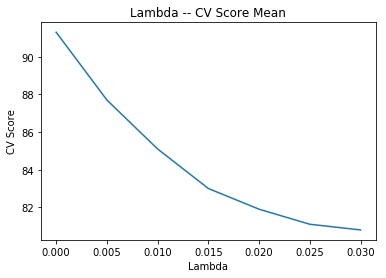

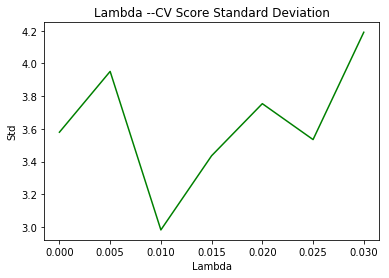

In [184]:
dic['1_layer_L2'] = cross_validation_plot(model_1_layer_L2, 0, 0.03, 0.005, X, Y)
plotting(dic['1_layer_L2'])

### 2-layer with/without L2 Regularization

90.7
90.70% (+/- 3.77%)
90.8
90.80% (+/- 3.31%)
87.8
87.80% (+/- 3.71%)
84.4
84.40% (+/- 3.38%)
81.3
81.30% (+/- 3.93%)
80.5
80.50% (+/- 4.08%)
78.5
78.50% (+/- 3.14%)


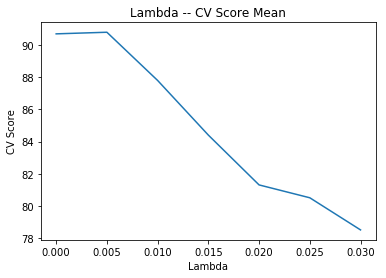

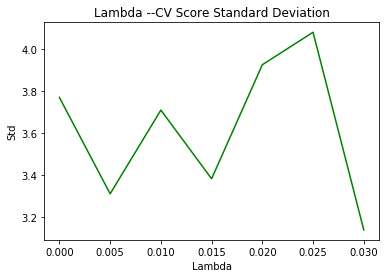

In [185]:
dic['2_layer_L2'] = cross_validation_plot(model_2_layer_L2, 0, 0.03, 0.005, X, Y)
plotting(dic['2_layer_L2'])

### 2-layer with First layer L2 Regularization

90.8
90.80% (+/- 3.03%)
91.0
91.00% (+/- 3.66%)
91.7
91.70% (+/- 3.23%)
90.0
90.00% (+/- 3.71%)
91.7
91.70% (+/- 2.93%)
91.4
91.40% (+/- 4.61%)
91.5
91.50% (+/- 3.47%)


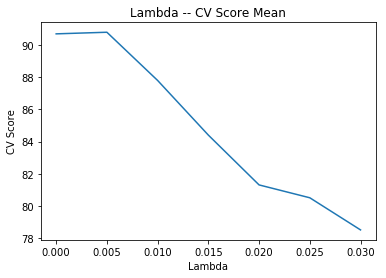

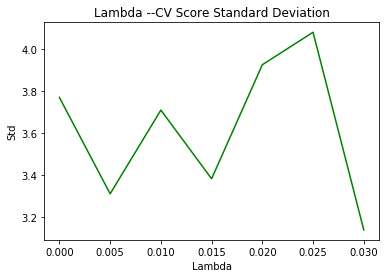

In [186]:
dic['2_layer_first_L2'] = cross_validation_plot(model_2_layer_first_L2, 0, 0.03, 0.005, X, Y)
plotting(dic['2_layer_L2'])

### 2-layer with Second Layer L2 Regularization

90.2
90.20% (+/- 3.87%)
91.6
91.60% (+/- 3.14%)
91.1
91.10% (+/- 3.56%)
91.0
91.00% (+/- 2.53%)
91.9
91.90% (+/- 2.70%)
91.6
91.60% (+/- 2.84%)
91.9
91.90% (+/- 3.30%)


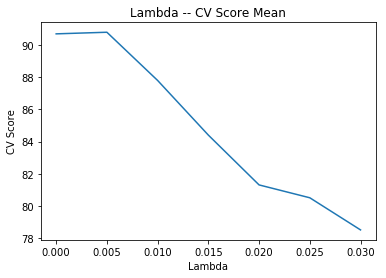

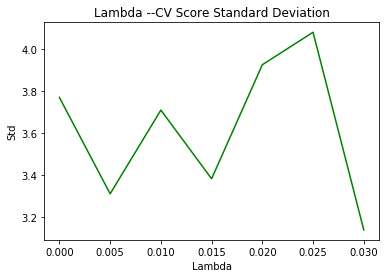

In [187]:
dic['2_layer_last_L2'] = cross_validation_plot(model_2_layer_last_L2, 0, 0.03, 0.005, X, Y)
plotting(dic['2_layer_L2'])

### 2-layer with/without Dropout

91.1
91.10% (+/- 4.30%)
92.1
92.10% (+/- 3.27%)
91.6
91.60% (+/- 3.26%)
91.1
91.10% (+/- 2.62%)
92.8
92.80% (+/- 2.89%)
91.5
91.50% (+/- 3.75%)
90.5
90.50% (+/- 3.83%)
91.5
91.50% (+/- 3.83%)
92.0
92.00% (+/- 3.35%)
91.0
91.00% (+/- 3.29%)
91.0
91.00% (+/- 3.77%)
89.9
89.90% (+/- 3.73%)


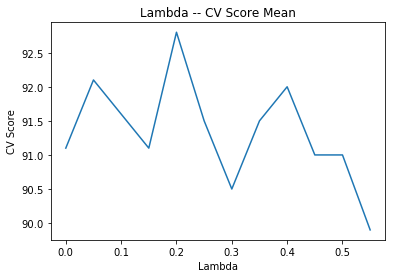

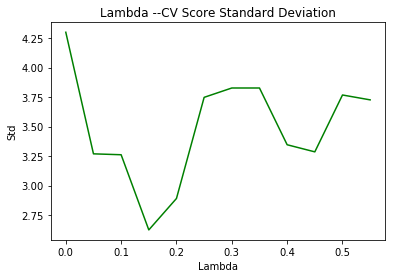

In [188]:
dic['2_layer_do'] = cross_validation_plot(model_2_layer_DR, 0, 0.5, 0.05, X, Y)
plotting(dic['2_layer_do'])